# Setup on Google Colab




In [ ]:
# !git clone https://github.com/JuliaXxj/ICLR2023.git
# !mv -v ./ICLR2023/* ./
# !rm -r ./ICLR2023/

Cloning into 'ICLR2023'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 28 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.
renamed './ICLR2023/FFN19-44-07-ep25' -> './FFN19-44-07-ep25'
renamed './ICLR2023/models.py' -> './models.py'
renamed './ICLR2023/README.md' -> './README.md'
renamed './ICLR2023/utils.py' -> './utils.py'


# Code

In [ ]:
# Get the benchmarks
VNN_BENCHMARK_DIR = "vnn_benchmarks"

!git clone https://github.com/stanleybak/vnncomp2021.git
!mkdir $VNN_BENCHMARK_DIR
!mv -v ./vnncomp2021/benchmarks/* ./$VNN_BENCHMARK_DIR
!rm -r ./vnncomp2021/

!pip3 install imageio
!pip3 install onnx

Cloning into 'vnncomp2021'...
remote: Enumerating objects: 5827, done.
remote: Total 5827 (delta 0), reused 0 (delta 0), pack-reused 5827
Receiving objects: 100% (5827/5827), 98.54 MiB | 21.31 MiB/s, done.
Resolving deltas: 100% (1862/1862), done.
Checking out files: 100% (792/792), done.
renamed './vnncomp2021/benchmarks/acasxu' -> './vnn_benchmarks/acasxu'
renamed './vnncomp2021/benchmarks/cifar10_resnet' -> './vnn_benchmarks/cifar10_resnet'
renamed './vnncomp2021/benchmarks/cifar2020' -> './vnn_benchmarks/cifar2020'
renamed './vnncomp2021/benchmarks/eran' -> './vnn_benchmarks/eran'
renamed './vnncomp2021/benchmarks/generate_random_instances.sh' -> './vnn_benchmarks/generate_random_instances.sh'
renamed './vnncomp2021/benchmarks/marabou-cifar10' -> './vnn_benchmarks/marabou-cifar10'
renamed './vnncomp2021/benchmarks/mnistfc' -> './vnn_benchmarks/mnistfc'
renamed './vnncomp2021/benchmarks/nn4sys' -> './vnn_benchmarks/nn4sys'
renamed './vnncomp2021/benchmarks/oval21' -> './vnn_benchmar

In [ ]:
from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier, NewTinyCNN, VNN_FFN_RELU_2, VNN_FFN_RELU_4, VNN_FFN_RELU_6
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
#from frozendict import frozendict
from datetime import datetime
import seaborn as sns
import pandas as pd
from absl import app, flags
from easydict import EasyDict
import torch.nn as nn
import json
import os
import onnx
from onnx import numpy_helper


colors = sns.color_palette("tab10")
%matplotlib inline

#Logging stuffs
import logging
import sys
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

#configs
epochs = 10
batch_size = 1000
test_batch_size = 10000
stable_batch_size = 60000
use_cuda = torch.cuda.is_available()
print("use_cuda: ",use_cuda)

lr = 0.01
log_interval = 100

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}

test_kwargs = {'batch_size': test_batch_size}
stable_kwargs = {'batch_size': stable_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': False}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    stable_kwargs.update(cuda_kwargs)

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])


use_cuda:  False


## Helper functions

In [ ]:
class Shift:
    def __init__(self, shift = 0):
        print("alive")
        self.shift = shift

    def __call__(self, arr):
        print("running")
        #print(arr)
        return arr
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"
    
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

def shift_and_roll(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:
    return torch.roll(arr, shifts = (x,y), dims = (0,1)) #indexing
def shift(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:

    pad = [0,0,0,0]
    x_start = 0
    x_end = 0
    y_start = 0
    y_end = 0
    if x >= 0:
        pad[0] = x
        x_start = 0
        x_end = 28
    else:
        pad[1] = abs(x)
        x_start = -28        
    
    if y >= 0:
        pad[2] = y
        y_start = 0
        y_end = 28
    else:
        pad[3] = abs(y)
        y_start= -28
        print("ys is {}".format(y_start))
    

    padder = torch.nn.ZeroPad2d(tuple(pad))
  
    result = padder(arr)

    if y < 0:
        y_end = result.shape[0]
    if x < 0:
        x_end = result.shape[1]
    
    return result[y_start:y_end, x_start:x_end]

def noisify(arr : torch.Tensor , distribution : torch.distributions.Distribution) -> torch.Tensor: #randomly add noise
   
    #print(distribution.sample(arr.size()).shape\\)
    #print(torch.reshape(distribution.sample(arr.size()), (28,28)).shape)
   
    noise = torch.reshape(distribution.sample(arr.size()), (arr.shape))
    return arr + noise

def transform_dataset(dataset):
    '''
    DO A STATE CHANGE
    '''
    shift_x = 1
    shift_y = 0
    mu = 1
    sigma = 1
    do_shift = False
    do_noisfy = True
    modification_string = "base"
    if do_shift:
        modification_string += " -shift {} {} - ".format(shift_x, shift_y)
    if do_noisfy:
        modification_string += " -noise added using gaussian using mean {} and stddev {}- ".format(mu, sigma)
    for i in range(dataset.data.shape[0]):
        if do_shift:
            dataset.data[i,:,:] = shift(dataset.data[i,:,:],shift_x, shift_y)
        
        if do_noisfy:
            gaussian = torch.distributions.Normal(loc = mu, scale = sigma)# loc = mu, scale = stddev

            dataset.data[i,:,:] = noisify(dataset.data[i,:,:], gaussian)
    return modification_string

def check_gradient(grad, label, last_sorted_grads, plot = False):
    logging.info("CHECKING GRADIENT FOR LABEL {}".format(label))
    sum_abs_grad = np.sum(abs(grad[label]), axis = 0)
    
    current_sorted_grad = (-sum_abs_grad).argsort()
    
#     if len(last_sorted_grads[label]) > 0:
#         for k in [100, 200, 300, 400]:
#             prev_top_k = set(last_sorted_grads[label][-1][:k])
#             current_top_k = set(current_sorted_grad[:k])
#             intersect = prev_top_k.intersection(current_top_k)
#             logging.info('k = {}. How many top Gradients are stable since last epoch?: {}'.format(k, len(intersect)))
        
    for k in [0, 9, 99, 199]:    
        logging.debug('{}th biggest gradient = {}'.format(k, np.sort(-sum_abs_grad)[k]))
    if plot:
        fig = plt.figure(figsize=(30, 1))
        plt.bar(range(sum_abs_grad.shape[0]), sum_abs_grad)
        plt.show()
        print(sum_abs_grad.max(), sum_abs_grad.argmax(), sum_abs_grad.min())

    return current_sorted_grad

class Patterns:
    def __init__(self, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, labels, layers):
        self._model = model
        self.label2patterns = {}
        self.label2idx = {}
        self._labels = labels
        self._layers = layers
        self._dataloader = dataloader
        self._populate()
        
    def _populate(self):
        
        label2patterns = {}
        label2idx = {}
        for label in self._labels:
            patterns = []
            filter_ids = []
            
            for data, target in self._dataloader:
                
                flter = np.where(target == label)
                filter_ids.append(flter)
                data = data[flter]
                logging.debug(data.shape[0])
                pattern = self._model.get_pattern(data, layers, device, flatten = True)
                logging.debug(pattern.shape)
                patterns.append(pattern)

            patterns = np.squeeze(np.concatenate(patterns, axis = 0))
            filter_ids = np.squeeze(np.concatenate(filter_ids, axis = 0))
            label2patterns[label] = patterns
            label2idx[label] = filter_ids
            
            logging.info(patterns.shape)
        
        #freeze
        self.label2patterns = dict(label2patterns)
        self.label2idx = dict(label2idx)
        
    def apply_filter(self, f):
        pass
    
    def unique():
        pass
    
    def query_pattern():
        pass

## Load Model & Datasets

In [ ]:
dataset1 = datasets.MNIST('./data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('./data', train=False, download=True,
                          transform=transform)


#transform_dataset(dataset1)
#modification_string = transform_dataset(dataset2)
modification_string = ""
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
vnn_models_layers ={
    "mnistfc":{
        "mnist-net_256x2.onnx": ['layers.0', 'layers.2', 'layers.4'],
        "mnist-net_256x4.onnx": ['layers.0', 'layers.2', 'layers.4', 'layers.6', 'layers.8'],
        "mnist-net_256x6.onnx": ['layers.0', 'layers.2', 'layers.4', 'layers.6', 'layers.8', 'layers.10', 'layers.12']
    }
}

py_models_layers ={
    "mnistfc":{
        "mnist-net_256x2.onnx": ['fc1', 'fc2', 'fc3'],
        "mnist-net_256x4.onnx": ['fc1', 'fc2', 'fc3', 'fc4', 'fc5'],
        "mnist-net_256x6.onnx": ['fc1', 'fc2', 'fc3', 'fc4', 'fc5', 'fc6', 'fc7']
    }
}

In [ ]:

#######################################################LOAD MODEL FROM VNN#################################################
benchmark = "mnistfc"
onnx_model_name = "mnist-net_256x4.onnx"
LOADPATH= os.path.join(VNN_BENCHMARK_DIR, benchmark, onnx_model_name)


onnx_model = onnx.load(LOADPATH)
model = VNN_FFN_RELU_4(28*28, 256, 10).to(device)
# print(onnx.helper.printable_graph(onnx_model.graph))


INTIALIZERS  = onnx_model.graph.initializer
onnx_weights = {}
onnx_bias = {}
for initializer in INTIALIZERS:
    W = numpy_helper.to_array(initializer)
    if "bias" in initializer.name:
        onnx_bias[initializer.name] = W
    elif "weight" in initializer.name:
        onnx_weights[initializer.name] = W
    else:
        assert False
    # print(W.shape)


onnx_layers = vnn_models_layers[benchmark][onnx_model_name]

onnx_weights_layer_names = [l + ".weight" for l in onnx_layers]
onnx_bias_layer_names = [l + ".bias" for l in onnx_layers]
# print(onnx_weights_layer_names, onnx_bias_layer_names)

model.update_all_weights(onnx_weights_layer_names, onnx_weights)
model.update_all_bias(onnx_bias_layer_names, onnx_bias)

#######################################################LOAD MODEL FROM ONNX#################################################
# LOADPATH = 'FFN19-44-07-ep25'
# model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
# model.load_state_dict(torch.load(LOADPATH, map_location=device))

with torch.no_grad():
    total = 0
    correct = 0
    for data, target in dataset2:
        # data_extend = data[None, :]
        if int(torch.argmax(model.to(device)(data.to(device)), dim = 1)) == target:
        # if int(torch.argmax(model.cuda()(data_extend.cuda()), dim = 1)) == target:
            correct += 1
        total+=1
    "accuracy {}".format( correct/total)
    modification_string = " -accuracy {}-".format( correct/total)
    print(modification_string)

/content/models.py:277: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  self.fc1.weight = torch.nn.Parameter(torch.from_numpy( new_weights[names_in_order[0]]).float())


 -accuracy 0.9764-


In [ ]:
layers = py_models_layers[benchmark][onnx_model_name]

labels = range(10)
K = 25
stable_loader = torch.utils.data.DataLoader(dataset1, **stable_kwargs)

all_patterns = Patterns(model = model,
                        dataloader = stable_loader,
                        labels = labels,
                        layers = layers)
all_test_patterns = Patterns(model = model,
                        dataloader = test_loader,
                        labels = labels,
                        layers = layers)

root - INFO - (5923, 1034)
root - INFO - (6742, 1034)
root - INFO - (5958, 1034)
root - INFO - (6131, 1034)
root - INFO - (5842, 1034)
root - INFO - (5421, 1034)
root - INFO - (5918, 1034)
root - INFO - (6265, 1034)
root - INFO - (5851, 1034)
root - INFO - (5949, 1034)
root - INFO - (980, 1034)
root - INFO - (1135, 1034)
root - INFO - (1032, 1034)
root - INFO - (1010, 1034)
root - INFO - (982, 1034)
root - INFO - (892, 1034)
root - INFO - (958, 1034)
root - INFO - (1028, 1034)
root - INFO - (974, 1034)
root - INFO - (1009, 1034)


In [ ]:
log_dir = "log_file"

if not os.path.isdir(log_dir):
    os.mkdir(log_dir)

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.bool_):
            return int(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)
    


all_stable_relus = []

all_alpha_patterns = {"model": LOADPATH}

write_log = True
if write_log:
    ReLU_exp_log = open(os.path.join(log_dir,"relu_exp_log{}.csv".format(datetime.now().strftime("%H-%M-%S"))), "w")
    ReLU_exp_json = open(os.path.join(log_dir,"relu_exp_data{}.json".format(datetime.now().strftime("%H-%M-%S"))), "w")
    ReLU_exp_log.write("Epsilon,Label,NumStableReLU,NumUniqueAP,Alpha Pattern Cover\n")


epsilon_to_patterns = dict()
# epsilons = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
epsilons = np.linspace(0, 0.5, num=51)

for epsilon in epsilons:
    alpha_patterns = {}
    label_to_most_common_pattern = dict()
    for label in all_patterns.label2patterns:
#     for label in [0,2,8]:
        patterns = all_patterns.label2patterns[label]
        print(patterns.shape)

        occuring_patterns = patterns.tolist() #make patterns into list of lists first dim is each example, second dim is the pattern
        most_common_pattern = max(occuring_patterns, key =  lambda x :occuring_patterns.count(x)) #argmax the count of each pattern

        #print("most common pattern: {}".format(most_common_pattern) )
        
        pattern_indices = list(filter( lambda x : most_common_pattern[x] , range(len(most_common_pattern))   ))#get true indices     
        #print("pattern_indices: {}".format(pattern_indices))
        label_to_most_common_pattern[label] = (pattern_indices,most_common_pattern)
        relu_sum = np.sum(patterns, axis = 0).squeeze()
        
        print("threshold: ", epsilon*patterns.shape[0], (1-epsilon)*patterns.shape[0])
        
#         print("relu_sum, layer-1 ", relu_sum[:256])
#         print("relu_sum, layer-2 ", relu_sum[256:384])
#         print("relu_sum, layer-3 ", relu_sum[384:448])
        print("relu_sum, prediction", relu_sum[448:458])
#         print("relu_sum", relu_sum[-10:])
        
        non_active_neurons = np.where(relu_sum<=epsilon*patterns.shape[0])
        active_neurons = np.where(relu_sum>=(1-epsilon)*patterns.shape[0])
        print("non active neurons: ", non_active_neurons)
        print("active neurons: ", active_neurons)

        stable_idx = np.concatenate([np.where(relu_sum<=epsilon*patterns.shape[0]), 
                                     np.where(relu_sum>=(1-epsilon)*patterns.shape[0])],
                                    axis = 1
                                    ).squeeze()
        neuro_idx = patterns.shape[1] - 10 + label
        if neuro_idx not in stable_idx:
            print(f"WARN: neuro_idx = {neuro_idx} for label {label} is not stable, let's include it anyway")
            stable_idx = np.append(stable_idx, neuro_idx)
        stable_idx = sorted(stable_idx) #sort the indices of the stable ReLUs. 
        unique_patterns, freq = np.unique(patterns[:, stable_idx ], axis = 0, return_counts=True)
        alpha_p = unique_patterns[np.argmax(freq)]
        print("unique patterns:", unique_patterns)
        print()
        print("Label is ", label, "-epsilon ", epsilon)
        print("Stable ReLUs", stable_idx)
        print("how many unique paths in the filtered pattern?", unique_patterns.shape)
        print("their freq\n", freq, freq.shape)
#         print("most prominent pattern", np.argmax(freq), alpha_p)
#         print("alpha_p is ", alpha_p)


        assert(len(stable_idx) == alpha_p.shape[-1])
        assert(freq.shape[0]==unique_patterns.shape[0])
#         alpha_patterns[label] = (stable_idx, tuple(alpha_p))
#         alpha_patterns[label] = {"stable_idx": stable_idx,
#                                 "alpha_pattern": alpha_p,
#                                 "alpha_pattern_coverage": freq.max()/freq.sum(),
#                                 "pattern_frequency": freq}
        alpha_patterns[label] = {"stable_idx": stable_idx,
                                 "active_neurons": active_neurons[0],
                                 "non_active_neurons": non_active_neurons[0],
                                "alpha_pattern": alpha_p,
                                "alpha_pattern_coverage": freq.max()/freq.sum(),
                                "pattern_frequency": freq}
    
#         print("pattern frequency:", freq)
        print("primary pattern coverage: ", freq.max()/freq.sum(),)

        if write_log:
            ReLU_exp_log.write("{},{},{},{},{}\n".format(epsilon, label, len(stable_idx), unique_patterns.shape[0], freq.max()/freq.sum()))
    all_alpha_patterns[epsilon] = alpha_patterns
    epsilon_to_patterns[epsilon] = label_to_most_common_pattern
json.dump(epsilon_to_patterns, open(os.path.join(log_dir,"most_common_patterns{}.json".format(datetime.now().strftime("%H-%M-%S"))), "w")) 
    
if write_log:
    ReLU_exp_log.close()
    json.dump(all_alpha_patterns, fp = ReLU_exp_json, indent=2, cls=NpEncoder)
    ReLU_exp_json.close()

Streaming output truncated to the last 5000 lines.
        249,  250,  252,  253,  254,  255,  256,  257,  262,  263,  264,
        265,  266,  267,  268,  269,  270,  271,  272,  274,  275,  276,
        277,  278,  279,  280,  281,  282,  283,  284,  285,  286,  287,
        288,  290,  291,  292,  293,  294,  295,  296,  297,  298,  299,
        301,  302,  303,  304,  306,  307,  308,  309,  310,  311,  312,
        313,  314,  315,  316,  317,  318,  319,  320,  321,  322,  323,
        324,  325,  326,  327,  328,  329,  330,  331,  332,  333,  334,
        335,  336,  337,  338,  340,  341,  342,  343,  344,  345,  346,
        347,  348,  349,  350,  351,  353,  354,  355,  356,  357,  358,
        360,  361,  362,  363,  364,  365,  366,  367,  368,  369,  370,
        371,  372,  373,  374,  375,  376,  377,  378,  379,  380,  381,
        382,  383,  385,  386,  388,  389,  391,  392,  393,  394,  395,
        396,  397,  398,  399,  400,  401,  402,  403,  404,  405,  406,


In [ ]:
for train_data, train_target in stable_loader:
    print(train_data.size())
    print(train_target.size())
    
for test_data, test_target in test_loader:
    print(test_data.size())
    print(test_target.size())
    
train_by_cls = {}
test_by_cls = {}

for picked_cls in range(10):
    train_cls_idx = train_target==picked_cls    

    sub_train_dataset = train_data[train_cls_idx].to(device)
    sub_train_targets = train_target[train_cls_idx].to(device)

    test_cls_idx = test_target==picked_cls

    sub_test_dataset = test_data[test_cls_idx].to(device)
    sub_test_targets = test_target[test_cls_idx].to(device)
        
    train_by_cls[picked_cls] = {}
    train_by_cls[picked_cls]["data"] = sub_train_dataset
    train_by_cls[picked_cls]["targets"] = sub_train_targets
    
    test_by_cls[picked_cls] = {}
    test_by_cls[picked_cls]["data"] = sub_test_dataset
    test_by_cls[picked_cls]["targets"] = sub_test_targets
    
    print(f"Train: for class {picked_cls}, total = {len(sub_train_targets)}")
    print(f"Test: for class {picked_cls}, total = {len(sub_test_targets)}")
    print()




torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])
Train: for class 0, total = 5923
Test: for class 0, total = 980

Train: for class 1, total = 6742
Test: for class 1, total = 1135

Train: for class 2, total = 5958
Test: for class 2, total = 1032

Train: for class 3, total = 6131
Test: for class 3, total = 1010

Train: for class 4, total = 5842
Test: for class 4, total = 982

Train: for class 5, total = 5421
Test: for class 5, total = 892

Train: for class 6, total = 5918
Test: for class 6, total = 958

Train: for class 7, total = 6265
Test: for class 7, total = 1028

Train: for class 8, total = 5851
Test: for class 8, total = 974

Train: for class 9, total = 5949
Test: for class 9, total = 1009



## For each $ϵ$, check how many test images of each class satisfy the alpha pattern

In [ ]:
csv_filename = onnx_model_name.replace(".onnx", "")+"_test_alpha_pattern_count.csv"
df_row_index = []
for i in range(10):
    row_name = "label{} ({})".format(i, len(test_by_cls[i]["targets"]))
    df_row_index.append(row_name)
print(df_row_index)

test_count_df = pd.DataFrame(index= df_row_index)
# test_count = []
epsilons = np.linspace(0, 0.5, num=51)

for epsilon in epsilons:
    print(f"For eps={epsilon} checking the number of test images of each class that satisfying the alpha pattern.")

    eps_test_count = []
    for picked_cls in range(10):
        cls_test_pattern = all_test_patterns.label2patterns[picked_cls]

        cls_eps_stable_idx = all_alpha_patterns[epsilon][picked_cls]["stable_idx"]
        cls_eps_alpha_pattern = all_alpha_patterns[epsilon][picked_cls]["alpha_pattern"]
        # cls_eps_alpha_pattern_active = all_alpha_patterns[epsilon][picked_cls]["active_neurons"]
        # cls_eps_alpha_pattern_nonactive = all_alpha_patterns[epsilon][picked_cls]["non_active_neurons"]


        # cls_test_data = test_by_cls[picked_cls]["data"]
        test_patterns_stable_neurons = cls_test_pattern[:, cls_eps_stable_idx]
        num_stable_neurons = len(cls_eps_stable_idx)

        check_patterns = test_patterns_stable_neurons == cls_eps_alpha_pattern
        # print(num_stable_neurons, check_patterns.sum(axis=-1))

        num_test_same_alpha_pattern = (check_patterns.sum(axis=-1) == num_stable_neurons).sum()
        # print(num_test_same_alpha_pattern)
        eps_test_count.append(num_test_same_alpha_pattern)
        print(f"class={picked_cls}, total = {num_test_same_alpha_pattern} / {len(cls_test_pattern)}")

    eps_test_count_df = pd.DataFrame(data=eps_test_count, columns=[epsilon], index=df_row_index)
    test_count_df = pd.concat((test_count_df, eps_test_count_df), axis=1)
    # test_count.append(eps_test_count)
# test_count = np.ndarray(eps_test_count)
# test_count_df = pd.DataFrame(data=test_count, columns=df_row_index, index=epsilons)
print(test_count_df.shape)
test_count_df.to_csv(os.path.join(log_dir, csv_filename))



['label0 (980)', 'label1 (1135)', 'label2 (1032)', 'label3 (1010)', 'label4 (982)', 'label5 (892)', 'label6 (958)', 'label7 (1028)', 'label8 (974)', 'label9 (1009)']
For eps=0.0 checking the number of test images of each class that satisfying the alpha pattern.
class=0, total = 967 / 980
class=1, total = 1124 / 1135
class=2, total = 997 / 1032
class=3, total = 980 / 1010
class=4, total = 959 / 982
class=5, total = 874 / 892
class=6, total = 937 / 958
class=7, total = 1003 / 1028
class=8, total = 941 / 974
class=9, total = 967 / 1009
For eps=0.01 checking the number of test images of each class that satisfying the alpha pattern.
class=0, total = 775 / 980
class=1, total = 959 / 1135
class=2, total = 792 / 1032
class=3, total = 787 / 1010
class=4, total = 766 / 982
class=5, total = 677 / 892
class=6, total = 726 / 958
class=7, total = 809 / 1028
class=8, total = 696 / 974
class=9, total = 828 / 1009
For eps=0.02 checking the number of test images of each class that satisfying the alpha p

In [ ]:
csv_filename = onnx_model_name.replace(".onnx", "")+"_test_alpha_pattern_count.csv"
# csv_filename = "test_alpha_pattern_count.csv"
df = pd.read_csv(os.path.join(log_dir, csv_filename), index_col=[0])


table_eps_idx = [0, 1, 5, 10, 15, 25, 50]
table_eps = [df.columns[i] for i in table_eps_idx]
print(table_eps)



first_table_headers = []
second_table_headers = []
for hc in df.index:
    first_table_headers.append(hc.split(" ")[0])
    second_table_headers.append(hc.split(" ")[1])

header_row = " ".join("{" + str(i)+ "}&" for i in range(0, 10))+ "{10}\\\\" 
table_row =  "{0:.3f}"+" ".join("&{" + str(i)+ "}" for i in range(1, 11))+ "\\\\ \n \\hline"


print(" \\hline")
print(header_row.format("", *first_table_headers))
print(header_row.format("", *second_table_headers)+ "\n \\hline\\hline")
for e in table_eps:
    print(table_row.format(float(e), *df[e].values))


['0.0', '0.01', '0.05', '0.1', '0.15', '0.25', '0.5']
 \hline
& label0& label1& label2& label3& label4& label5& label6& label7& label8&label9\\
& (980)& (1135)& (1032)& (1010)& (982)& (892)& (958)& (1028)& (974)&(1009)\\
 \hline\hline
0.000&967 &1124 &997 &980 &959 &874 &937 &1003 &941 &967\\ 
 \hline
0.010&775 &959 &792 &787 &766 &677 &726 &809 &696 &828\\ 
 \hline
0.050&376 &456 &261 &320 &259 &226 &200 &357 &192 &277\\ 
 \hline
0.100&111 &126 &43 &92 &76 &24 &45 &144 &44 &73\\ 
 \hline
0.150&50 &27 &8 &20 &19 &5 &4 &51 &19 &25\\ 
 \hline
0.250&5 &0 &0 &2 &0 &0 &1 &0 &0 &0\\ 
 \hline
0.500&0 &0 &0 &0 &0 &0 &0 &0 &0 &0\\ 
 \hline


## For each $ϵ$, check overlap of the alpha pattern of each pair of class

In [ ]:
csv_filename = onnx_model_name.replace(".onnx", "")+ "_alpha_pattern_overlap.csv"
json_filename = onnx_model_name.replace(".onnx", "")+ "_alpha_pattern_overlap.json"
epsilons = np.linspace(0, 0.5, num=51)

overlap = {}
# overlap_count = np.zeros((10, 10))

for epsilon in epsilons:
    overlap[epsilon] = {}
    for c1 in range(10):
        c1_active = all_alpha_patterns[epsilon][c1]["active_neurons"]
        c1_nonactive = all_alpha_patterns[epsilon][c1]["non_active_neurons"]
        for c2 in range(c1, 10):
            pair_key = f"({c1}, {c2})"            

            c2_active = all_alpha_patterns[epsilon][c2]["active_neurons"]
            c2_nonactive = all_alpha_patterns[epsilon][c2]["non_active_neurons"]

            active_overlap = np.intersect1d(c1_active, c2_active).tolist()
            nonactive_overlap = np.intersect1d(c1_nonactive, c2_nonactive).tolist()

            overlap[epsilon][pair_key] = {}
            overlap[epsilon][pair_key]["active"] = active_overlap
            overlap[epsilon][pair_key]["nonactive"] = nonactive_overlap
            # overlap_count[c1, c2] = len(active_overlap) + len(nonactive_overlap)
            # overlap_count[c2, c1] = len(active_overlap) + len(nonactive_overlap)
    

out_file = open(os.path.join(log_dir,json_filename), "w")
json.dump(overlap, out_file, indent = 4)
out_file.close()

# overlap_count_df = pd.DataFrame(overlap_count,columns = [f"label{i}" for i in range(10)], index=[f"label{i}" for i in range(10)])
# overlap_count_df.to_csv(os.path.join(log_dir, csv_filename))
            

['0.0', '0.01', '0.05', '0.1', '0.15', '0.25', '0.5']
[1.         0.92007797 0.80896686 0.8791423  0.93567251 0.9005848
 0.95906433 0.92202729 0.85769981 0.89668616]



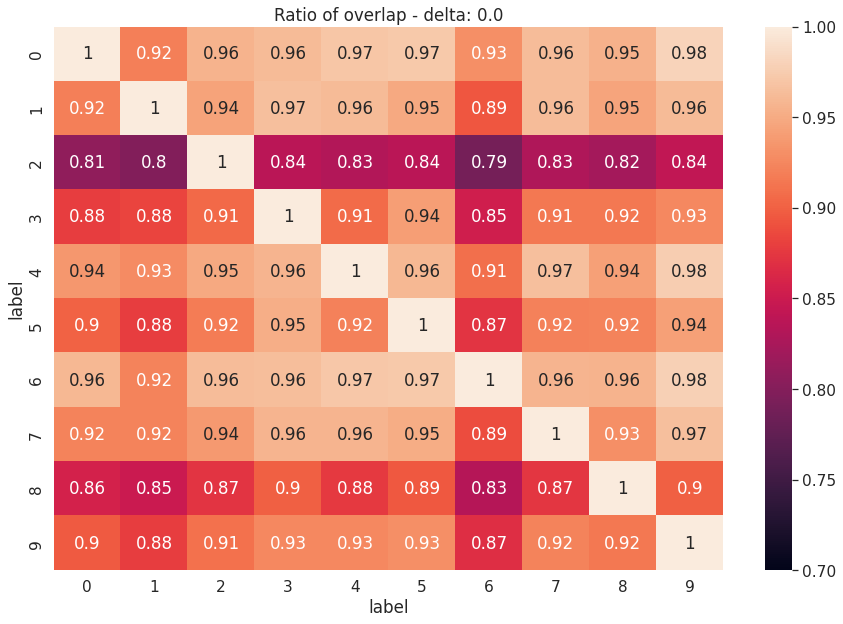

[1.         0.81216931 0.76322751 0.80820106 0.81481481 0.81613757
 0.84391534 0.80820106 0.82407407 0.7989418 ]



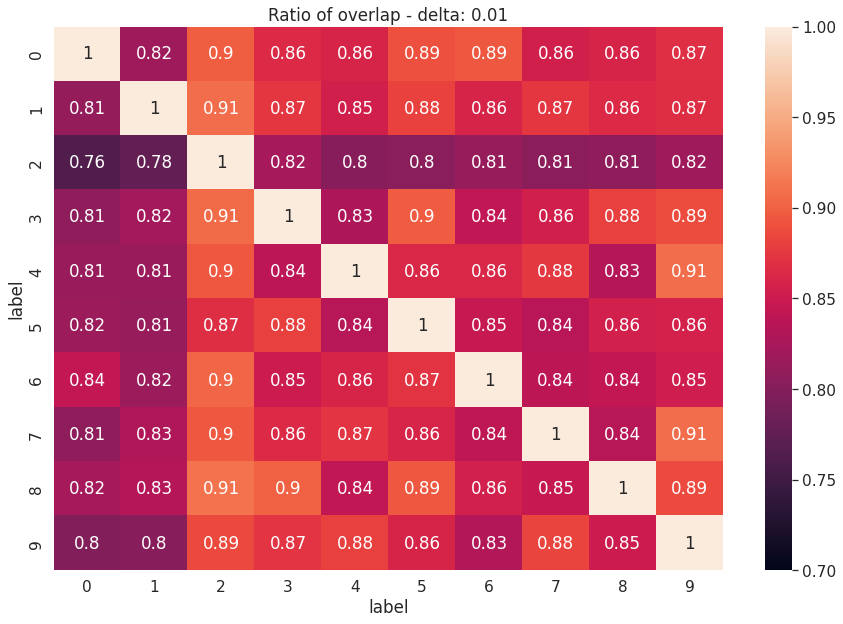

[1.         0.78770302 0.81670534 0.84454756 0.82018561 0.84106729
 0.83526682 0.83410673 0.86426914 0.84802784]



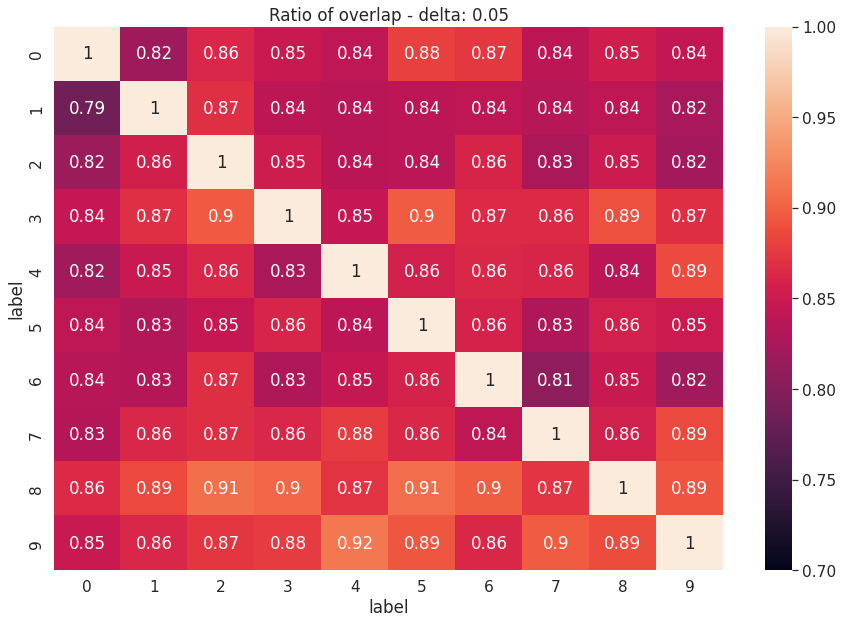

[1.         0.79825518 0.84514722 0.85169029 0.83969466 0.84514722
 0.84078517 0.85059978 0.87677208 0.86586696]



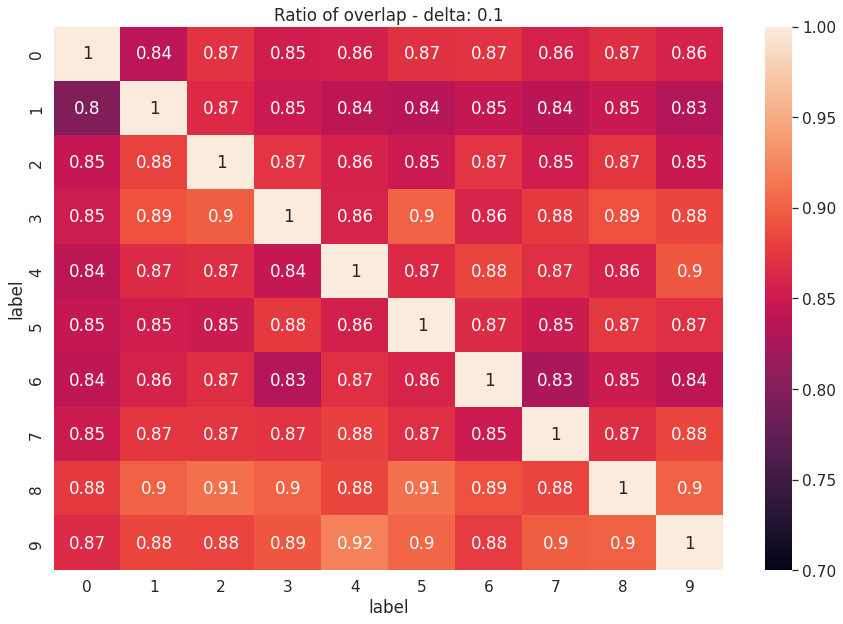

[1.         0.80531915 0.86808511 0.8606383  0.85531915 0.86276596
 0.85744681 0.8606383  0.87553191 0.87021277]



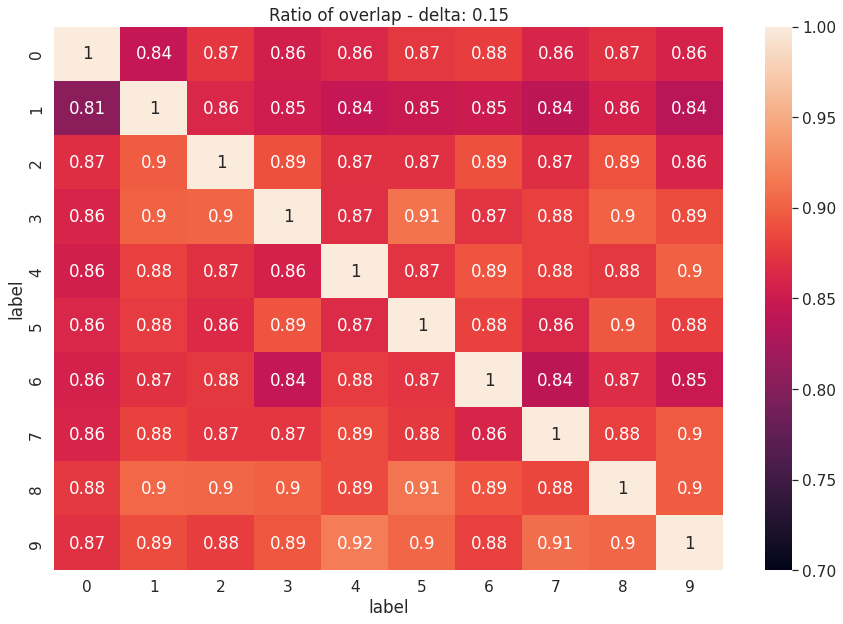

[1.         0.82974359 0.89333333 0.87487179 0.87076923 0.87589744
 0.86564103 0.87384615 0.89025641 0.88410256]



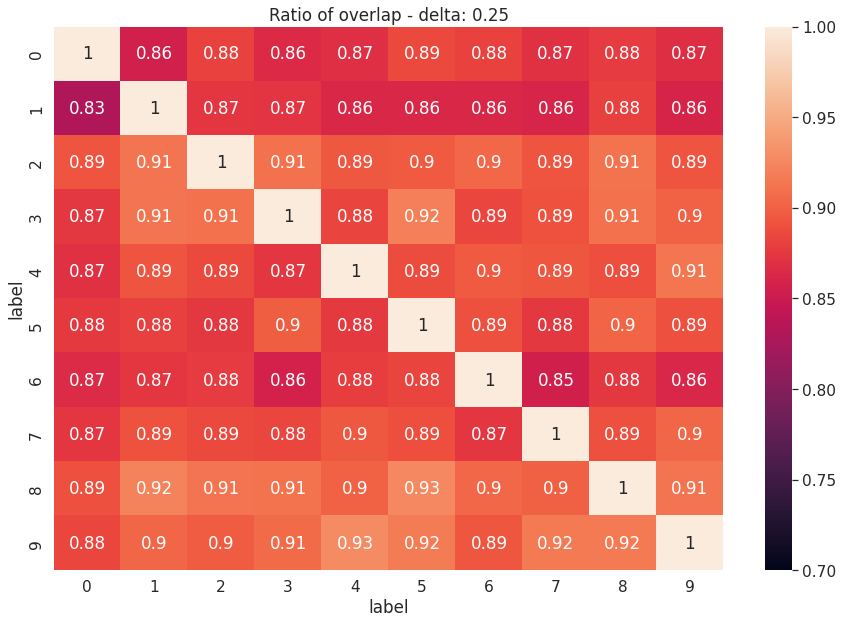

[1.         0.86266925 0.90135397 0.87814313 0.87717602 0.88974855
 0.88974855 0.88201161 0.9032882  0.88297872]



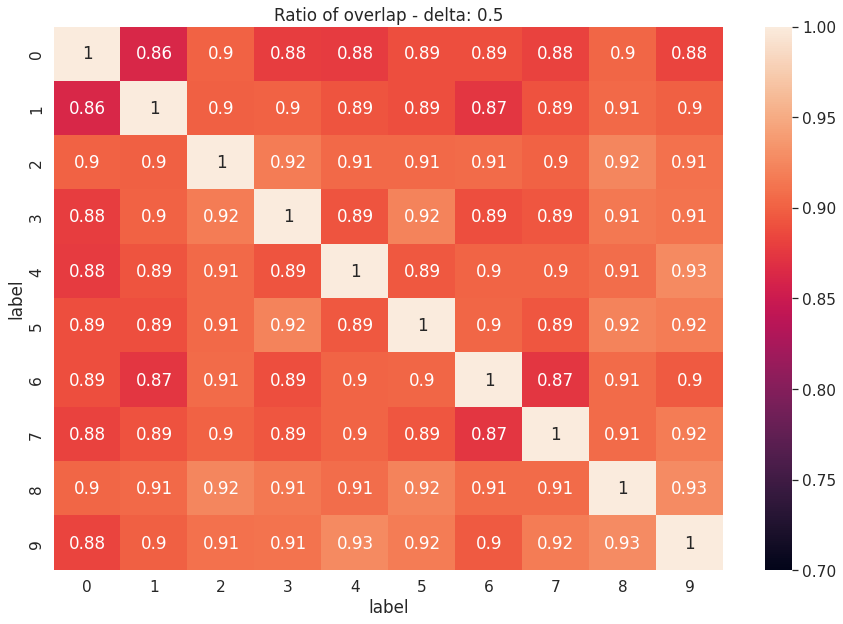

In [ ]:
img_dir = "images"
if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

json_filename = onnx_model_name.replace(".onnx", "")+ "_alpha_pattern_overlap.json"

# f = open(os.path.join(json_filename))

f = open(os.path.join(log_dir,json_filename))
data = json.load(f)
f.close()

table_eps_idx = [0, 1, 5, 10, 15, 25, 50]
json_epsilons = list(data.keys())

table_eps = [json_epsilons[i] for i in table_eps_idx]
print(table_eps)

first_table_headers = [f"label{i}" for i in range(10)]


header_row = " ".join("{" + str(i)+ "}&" for i in range(0, 10))+ "{10}\\\\" 
table_row =  "{0}"+" ".join("&{" + str(i)+ "}" for i in range(1, 11))+ "\\\\ \n \\hline"
for e in table_eps:
    active_overlap_count = np.zeros((10, 10), dtype=int)
    nonactive_overlap_count = np.zeros((10, 10), dtype=int)
    total_overlap_ratio = np.zeros((10, 10))
    for c1 in range(10):
        for c2 in range(c1, 10):
            pair_key = f"({c1}, {c2})"
            active_overlap = len(data[e][pair_key]["active"])
            nonactive_overlap = len(data[e][pair_key]["nonactive"])

            active_overlap_count[c1, c2] = active_overlap
            active_overlap_count[c2, c1] = active_overlap
            nonactive_overlap_count[c1, c2] = nonactive_overlap
            nonactive_overlap_count[c2, c1] = nonactive_overlap
    
    total_overlap_count = active_overlap_count + nonactive_overlap_count

    print(total_overlap_count[0]/total_overlap_count[0, 0] )
    print()
    for c1 in range(10):
        for c2 in range(10):
            total_overlap_ratio[c1, c2] = total_overlap_count[c1, c2]/ total_overlap_count[c2, c2]

            # if c1 >= c2:
            #     total_overlap_ratio[c1, c2] = total_overlap_count[c1, c2]/ total_overlap_count[c1, c1]
            # else:
            #     total_overlap_ratio[c1, c2] = total_overlap_count[c1, c2]/ total_overlap_count[c2, c2]

    total_overlap_count_df = pd.DataFrame(total_overlap_ratio, columns=[f"{i}" for i in range(10)], index=[f"{i}" for i in range(10)])

    f= plt.figure(figsize=(15, 10))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(total_overlap_count_df, annot=True, vmin=0.7, vmax=1) # font size

    plt.title(f"Ratio of overlap - delta: {e}")
    plt.xlabel("label")
    plt.ylabel("label")
    plt.savefig(os.path.join(img_dir, f"overlap_map_{e.replace('.', '-')}"))
    plt.show()
    plt.close(f)

    # second_table_headers = [f"({active_overlap_count[i, i]})" for i in range(10)]
    
    # print(f"===============Table for epsilon={e}====================")
    # print(" \\hline")
    # print(header_row.format("", *first_table_headers))
    # print(header_row.format("", *second_table_headers)+ "\n \\hline\\hline")
    # for c in range(10):
    #     print(table_row.format(f"label{c}", *total_overlap_count[c]))

# len(data[table_eps[0]]["(1, 2)"]["nonactive"])

In [ ]:
extension_zip = ".zip"

log_zip = log_dir + extension_zip
img_zip = img_dir + extension_zip
!zip -r $log_zip $log_dir
!zip -r $img_zip $img_dir

# from google.colab import files
# files.download(log_zip)
# files.download(img_zip)

updating: log_file/ (stored 0%)
updating: log_file/relu_exp_data17-40-58.json (deflated 97%)
updating: log_file/relu_exp_log17-40-58.csv (deflated 69%)
updating: log_file/mnist-net_256x4_test_alpha_pattern_count.csv (deflated 66%)
updating: log_file/most_common_patterns18-13-57.json (deflated 96%)
updating: log_file/mnist-net_256x4_alpha_pattern_overlap.json (deflated 97%)
updating: images/ (stored 0%)
updating: images/overlap_map_0-01.png (deflated 5%)
updating: images/overlap_map_0-0.png (deflated 5%)
updating: images/overlap_map_0-5.png (deflated 7%)
updating: images/overlap_map_0-25.png (deflated 6%)
updating: images/overlap_map_0-15.png (deflated 6%)
updating: images/overlap_map_0-1.png (deflated 6%)
updating: images/overlap_map_0-05.png (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>